In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import vmlab

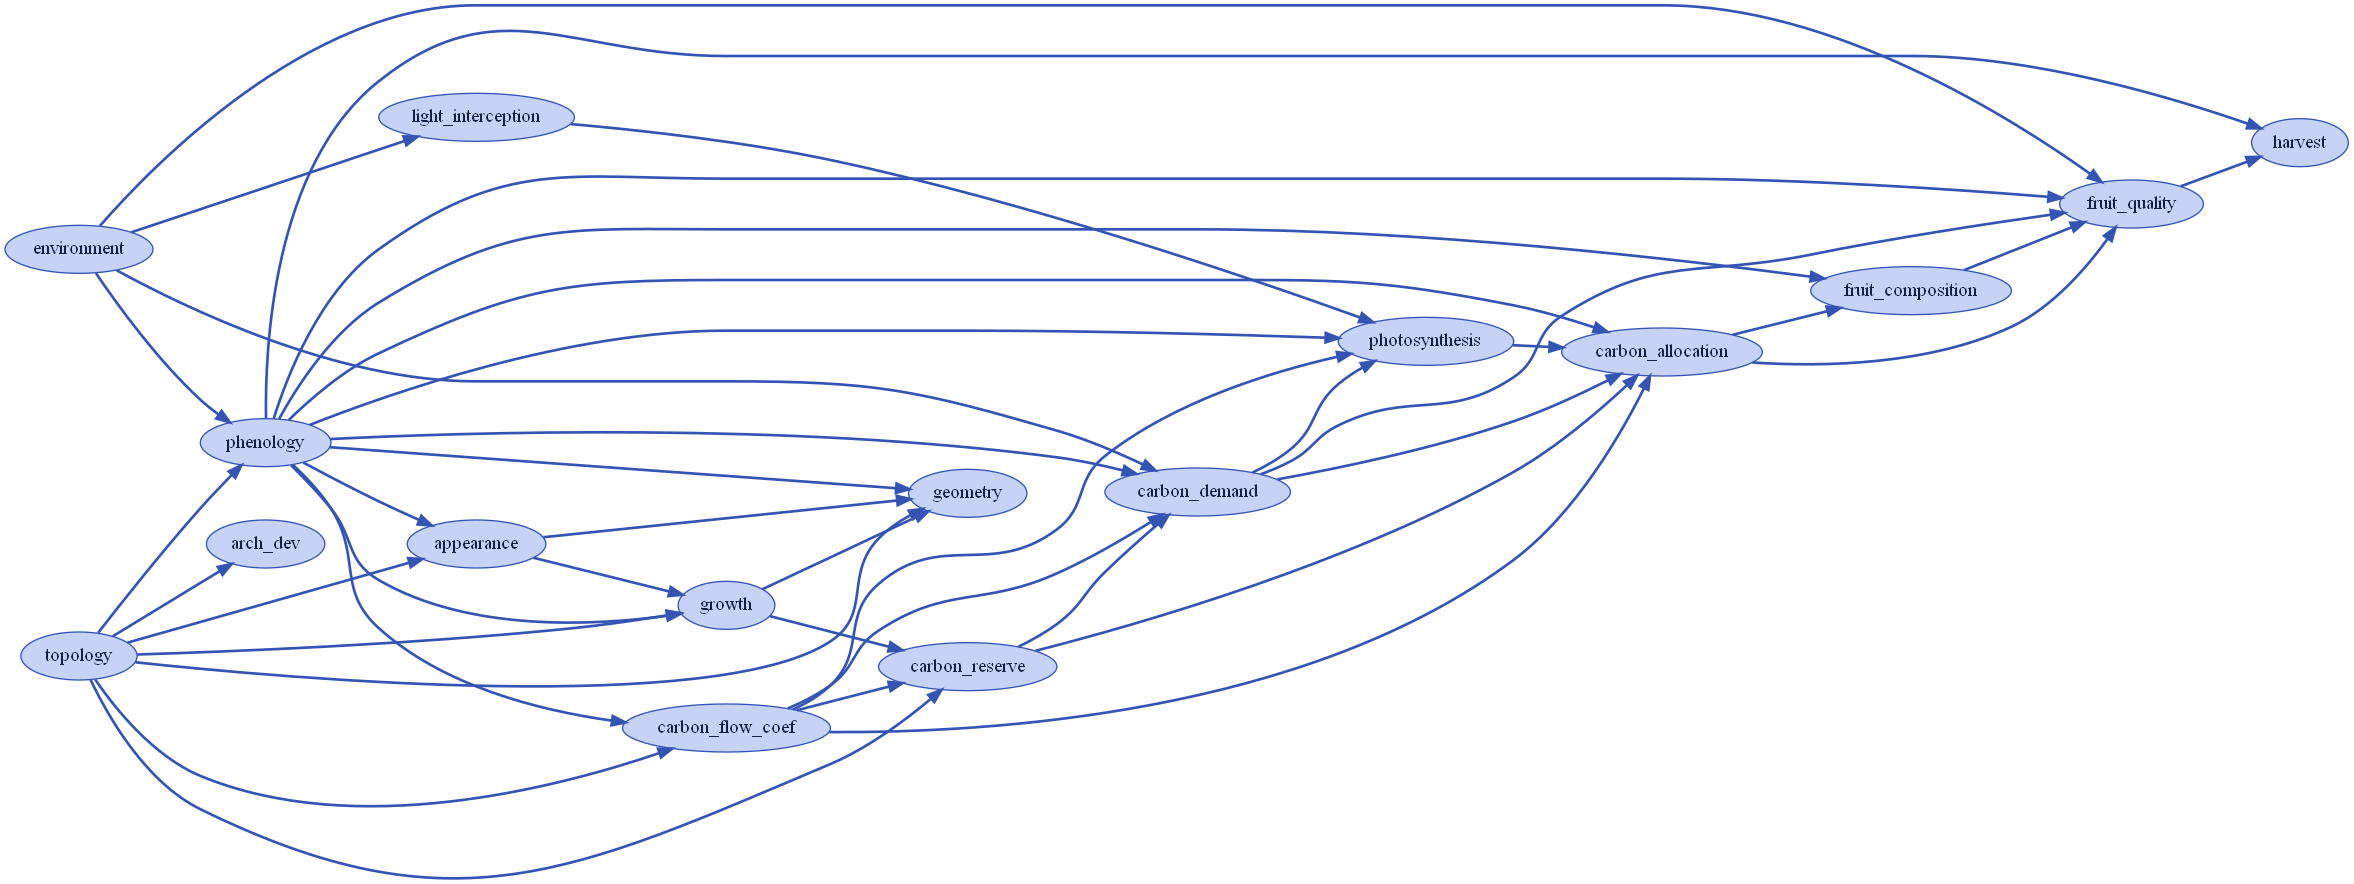

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import harvest
fruit_model = fruit_model.update_processes({'harvest': harvest.HarvestByQuality})
fruit_model.visualize()

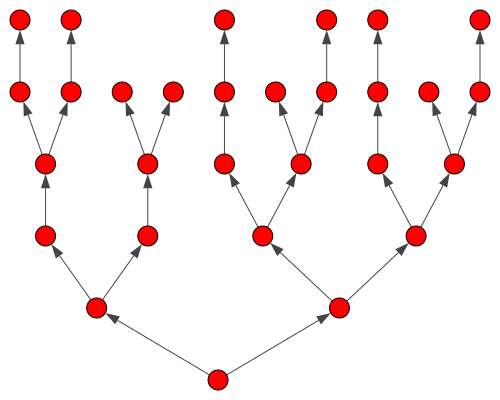

In [3]:
tree = pd.read_csv('../share/trees/branch_F14_25.csv')
graph = vmlab.load_graph(tree)
vmlab.check_graph(graph)
layout = graph.layout_reingold_tilford()
layout.rotate(-180)
ig.plot(graph, bbox=(0,0,500,400), layout=layout)

In [14]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=tree,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='../share/setup/fruit_model_branch.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'carbon_flow_coef__max_distance_to_fruit': 10,
        'geometry__interpretation_freq': 1
    },
    output_vars={
        'topology': {
            'adjacency': 'day'
        },
        'environment': {
            'TM_day': 'day',
            'RH_day': 'day'
        },
        'carbon_allocation': {
            'DM_fruit': 'day',
            'DM_flesh': 'day'
        },
        'harvest': {
            'ripeness_index': 'day',
            'nb_fruit_harvested': None
        },
        'growth': {
            'nb_leaf': None,
        },
        'fruit_quality': {
            'FM_fruit': 'day',
            'W_flesh': 'day',
            'sucrose': 'day'
        }
    }
)

In [15]:
ds_out = vmlab.run(setup, fruit_model, geometry=True)

SceneWidget(scenes=[{'id': 'rgxYaCgEF6oXHXxIHOfPfUNfM', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

d:\gitrepos\vmango-lab\vmlab\processes\carbon_allocation.py:279: UserWarning: Vegetative part of the system dies ...
  warnings.warn('Vegetative part of the system dies ...')


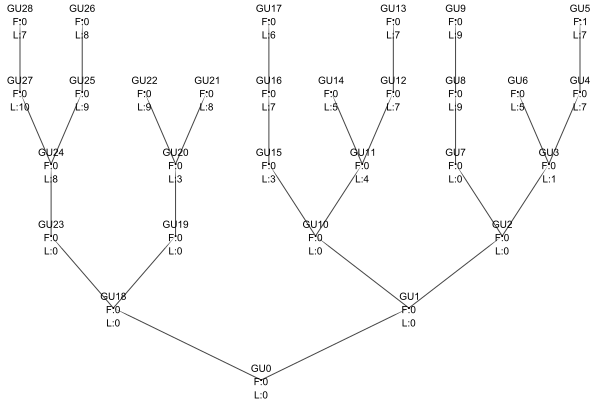

In [6]:
g = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency[-1].data.astype(np.int64)])
layout = g.layout_reingold_tilford(root=0.)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(600, 400), **{
    'vertex_size': 1,
    'vertex_label_size': 10,
    'edge_arrow_width': 0.1,
    'vertex_label': [
        f'GU{idx}\nF:{int(ds_out.harvest__nb_fruit_harvested.data[idx])}\nL:{int(ds_out.growth__nb_leaf.data[idx])}' for idx in g.vs.indices
    ]
})

<xarray.DataArray 'fruit_quality__FM_fruit' ()>
array(420.83725, dtype=float32)

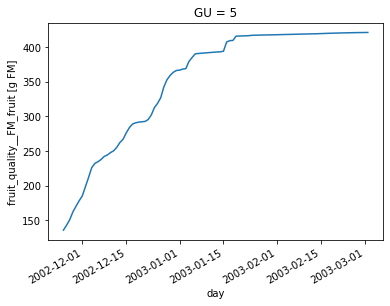

In [16]:
ds_out.fruit_quality__FM_fruit.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).plot()
ds_out.fruit_quality__FM_fruit.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).max()

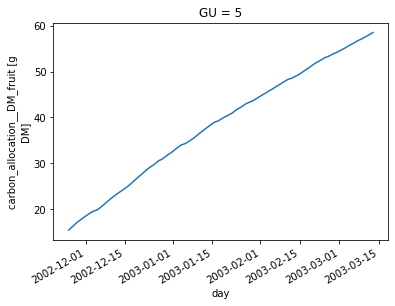

In [13]:
ds_out.carbon_allocation__DM_fruit.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).plot()
ds_out.carbon_allocation__DM_fruit.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).max()

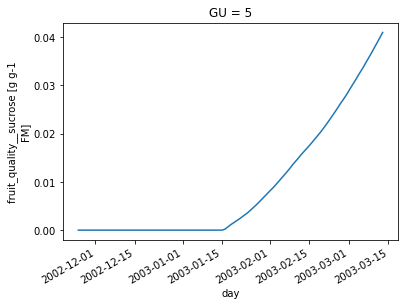

In [10]:
ds_out.fruit_quality__sucrose.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).plot()

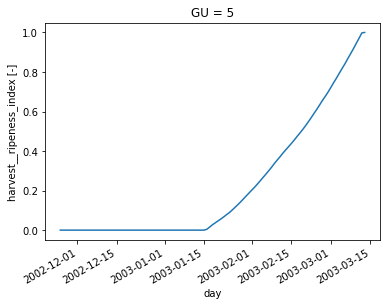

In [11]:
ds_out.harvest__ripeness_index.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).plot()

In [ ]:
ds_out.environment__TM_day.sel({'day': slice('2003-01-01', '2003-04-01')}).plot(col_wrap=6)

In [ ]:
ds_out.environment__RH_day.sel({'day': slice('2003-01-01', '2003-04-01')}).plot(col_wrap=6)